In [15]:
from typing import Dict,TypedDict
from langgraph.graph import StateGraph,END
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.chat_models import ChatOllama
from IPython.display import display,Image
from langchain_core.runnables.graph import MermaidDrawMethod
from dotenv import load_dotenv
import os



In [22]:
llm = ChatOllama(
    model="llama3",
    temperature=0
)
print(llm.invoke("Say 'LLaMA is working'").content)


LLaMA is working


In [23]:
#defining state class to hold the query as we want the category and sentiment
class State(TypedDict):
    query:str
    category:str
    sentiment:str
    response:str


In [24]:
# nodes
def categorize(state: State) -> State:
    """Categorize the customer query into Technical, Billing, or General."""
    prompt = ChatPromptTemplate.from_template(
        "Categorize the following customer query into one of these categories: "
        "Technical, Billing, General.\n"
        "Respond with ONLY the category name.\n"
        "Query: {query}"
    )
    chain = prompt | llm
    category = chain.invoke({"query": state["query"]}).content.strip()
    return {"category": category}

def analyze_sentiment(state: State) -> State:
    """Analyze the sentiment of the customer query."""
    prompt = ChatPromptTemplate.from_template(
        "Analyze the sentiment of the following customer query.\n"
        "Respond with ONLY one word: Positive, Neutral, or Negative.\n"
        "Query: {query}"
    )
    chain = prompt | llm
    sentiment = chain.invoke({"query": state["query"]}).content.strip()
    return {"sentiment": sentiment}


def handle_technical(state: State) -> State:
    """Provide a technical support response."""
    prompt = ChatPromptTemplate.from_template(
        "You are a technical support agent.\n"
        "Provide a clear and helpful response to the following query:\n"
        "{query}"
    )
    chain = prompt | llm
    response = chain.invoke({"query": state["query"]}).content
    return {"response": response}

def handle_billing(state: State) -> State:
    """Provide a billing support response."""
    prompt = ChatPromptTemplate.from_template(
        "You are a billing support agent.\n"
        "Provide a clear and professional response to the following query:\n"
        "{query}"
    )
    chain = prompt | llm
    response = chain.invoke({"query": state["query"]}).content
    return {"response": response}



def handle_general(state: State) -> State:
    """Provide a general support response."""
    prompt = ChatPromptTemplate.from_template(
        "You are a customer support agent.\n"
        "Provide a helpful response to the following query:\n"
        "{query}"
    )
    chain = prompt | llm
    response = chain.invoke({"query": state["query"]}).content
    return {"response": response}


def escalate(state: State) -> State:
    """Escalate the query to a human agent."""
    return {
        "response": (
            "This query has been escalated to a human agent "
            "due to negative sentiment."
        )
    }


def route_query(state:State)->str:
    """Route the query based on its sentiment and category."""
    if state["sentiment"] == "Negative":
        return "escalate"
    elif state["category"] == "Technical":
        return "handle_technical"
    elif state["category"] == "Billing":
        return "handle_billing"
    else:
        return "handle_general"



In [25]:
#create graph and configure 
#nodes
workflow=StateGraph(State)
workflow.add_node("categorize",categorize)
workflow.add_node("analyze_sentiment",analyze_sentiment)
workflow.add_node("handle_technical",handle_technical)
workflow.add_node("handle_billing",handle_billing)
workflow.add_node("handle_general",handle_general)
workflow.add_node("escalate",escalate)
# edges

workflow.add_edge("categorize", "analyze_sentiment")
workflow.add_conditional_edges(
    "analyze_sentiment",
    route_query,
    {
        "handle_technical": "handle_technical",
        "handle_billing": "handle_billing",
        "handle_general": "handle_general",
        "escalate": "escalate"
    }
)

workflow.add_edge("handle_technical",END)
workflow.add_edge("handle_billing",END)
workflow.add_edge("handle_general",END)
workflow.add_edge("escalate",END)

workflow.set_entry_point("categorize")

app=workflow.compile()


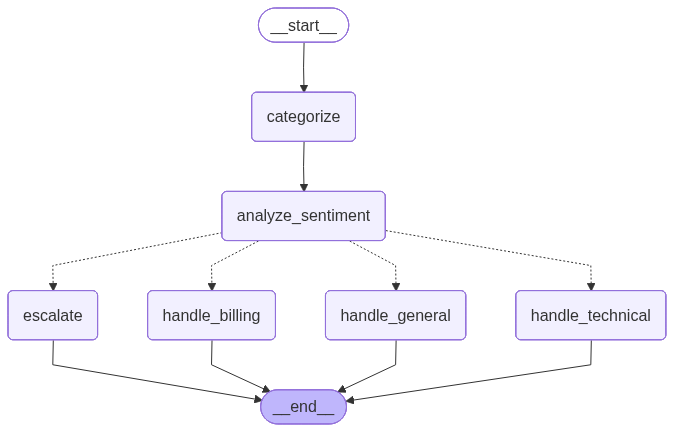

In [26]:
display(Image(
    app.get_graph().draw_mermaid_png(
        draw_method=MermaidDrawMethod.API
    )
))

In [27]:
def run_customer_support(query: str) -> Dict[str, str]:
    """Process a customer query through the LangGraph workflow.
    
    Args:
        query (str): The customer's query
        
    Returns:
        Dict[str, str]: A dictionary containing the query's category, sentiment, and response
    """
    results = app.invoke({"query": query})
    return {
        "category": results["category"],
        "sentiment": results["sentiment"],
        "response": results["response"]
    }

In [28]:
# Test
query = "My internet connection keeps dropping. Can you help?"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")
print("\n")

# handle_technical

query = "I need help talking to chatGPT"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")
print("\n")

# handle_billing

query = "where can i find my receipt?"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")
print("\n")

# handle_general

query = "What are your business hours?"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")

Query: My internet connection keeps dropping. Can you help?
Category: Technical
Sentiment: Neutral
Response: I'd be happy to help you troubleshoot your internet connection issues.

To better assist you, can you please provide me with some more information about your issue?

1. What type of internet service do you have (e.g., DSL, cable, fiber)?
2. How often does the connection drop? Is it constant or intermittent?
3. Are there any error messages or lights on your router or modem that might indicate what's causing the issue?
4. Have you recently made any changes to your network setup or devices connected to it?
5. Can you try restarting your router and modem, and see if that resolves the issue?

In the meantime, here are some general steps you can take to troubleshoot the issue:

1. Check your physical connection: Make sure all cables are securely plugged in and not damaged.
2. Restart your router and modem: This often resolves connectivity issues.
3. Check for outages: Visit our websit